In [12]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout,MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from functions import plot_images, emotion_detection
from tensorflow.keras.utils import plot_model

In [13]:
print(tf.__version__)

2.5.0


In [14]:
gpus = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", gpus)

Num GPUs Available:  1


In [4]:
#unzip data 
path_to_zip_file = 'fer2013.zip'
directory_to_extract_to = 'fer2013'
import zipfile
try:
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
except Exception as error:
    print(error)

[Errno 2] No such file or directory: 'fer2013.zip'


In [19]:
DIR_TRAIN = './fer2013/train'
DIR_TEST = './fer2013/test'
BATCH_SIZE=64
IMG_SIZE=(48, 48)
IMG_SHAPE=IMG_SIZE + (3,)
FRACTION=0.3

In [20]:
train_data = image_dataset_from_directory(
    DIR_TRAIN,
    labels="inferred",
    label_mode="categorical",
    # color_mode='grayscale',
     subset='training',
    validation_split=FRACTION,
    shuffle=True,
    seed=42,
    image_size=IMG_SIZE
)

Found 30547 files belonging to 7 classes.
Using 21383 files for training.


In [21]:
val_data = image_dataset_from_directory(
    DIR_TRAIN,
    labels="inferred",
    label_mode="categorical",
    # color_mode='grayscale',
     subset='validation',
    validation_split=FRACTION,
    shuffle=True,
    seed=42,
    image_size=IMG_SIZE
)

Found 30547 files belonging to 7 classes.
Using 9164 files for validation.


In [22]:
test_data = image_dataset_from_directory(
    DIR_TEST,
    labels="inferred",
    label_mode="categorical",
    # color_mode='grayscale',
    seed=42,
    image_size=IMG_SIZE
)

Found 7178 files belonging to 7 classes.


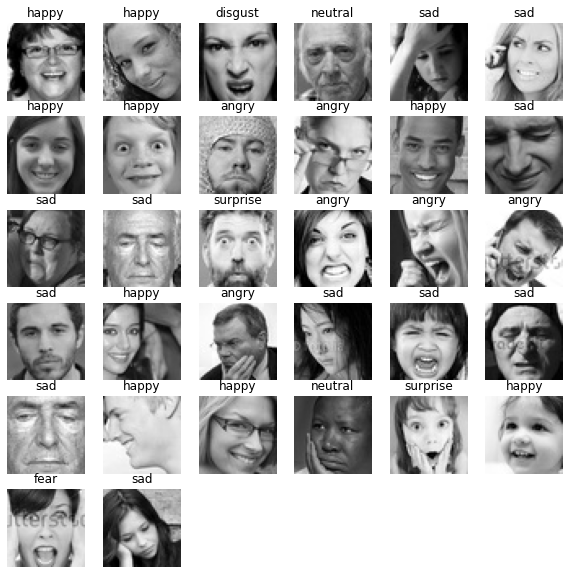

In [23]:
plot_images(train_data)

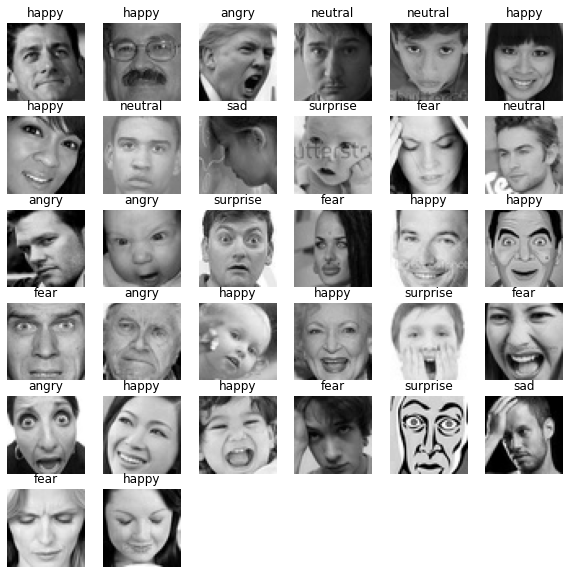

In [24]:
plot_images(test_data)

In [25]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [26]:
#rescaling images
train_data = train_data.map(process)
val_data = val_data.map(process)
test_data = test_data.map(process)

In [ ]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
PATH='models/'
#define callbacks
def get_callbacks(model_name):
    chk_path = f'{PATH} + {model_name}Net.h5'
    log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    checkpoint = ModelCheckpoint(filepath=chk_path,
                                 save_best_only=True,
                                 verbose=1,
                                 mode='min',
                                 moniter='val_loss')

    earlystop = EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=5, 
                              verbose=1, 
                              restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=6, 
                                  verbose=1, 
                                  min_delta=0.0001)


    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    csv_logger = CSVLogger(f'{PATH} + {model_name}-training.log')

    callbacks = [checkpoint, reduce_lr, csv_logger, earlystop]
    return callbacks

In [28]:
EPOCHS = 50

In [29]:
def train_model(model, data, num_epoch, callbacks):
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001, decay=1e-6),
                  metrics=['accuracy'])
    gpus = len(tf.config.list_physical_devices('GPU'))
    if (gpus != 0):
        device = '/GPU:0'
    else:
        device = '/CPU:0'
    print(f'model is trained on {device}')
    with tf.device(device):
        model_info = model.fit(
                train_data,
                steps_per_epoch=len(data[0]),
                epochs=num_epoch,
                validation_data=data[1],
                validation_steps=len(data[1]),
                callbacks=callbacks)
    return model_info

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [31]:
def get_model_pretrained(model_arch):
    pretrained_model = model_arch(include_top=False,
                         pooling='none',
                         input_shape=(48, 48, 3),
                         weights='imagenet')
    pretrained_model.trainable = False
    x = GlobalMaxPooling2D()(pretrained_model.output)
    x = Dense(2048, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(7, activation='softmax')(x)
    return Model(pretrained_model.input, output)  

In [32]:
custom_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           input_shape=IMG_SHAPE),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')])
custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

In [26]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [27]:
custom_model1 = get_model(IMG_SHAPE)
custom_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 22, 22, 256)      

In [28]:
from tensorflow.keras.applications import VGG16
vgg16_model = get_model_pretrained(VGG16)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [29]:
from tensorflow.keras.applications import ResNet50
resNet50_model = get_model_pretrained(ResNet50)
resNet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [33]:
from tensorflow.keras import backend as K
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
callbacks = get_callbacks('custom_model')
history_custom_model = train_model(model=custom_model, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=callbacks)

model is trained on /GPU:0
Epoch 1/50
669/669 [==============================] - 132s 161ms/step - loss: 1.7668 - accuracy: 0.2827 - val_loss: 1.6315 - val_accuracy: 0.3759

Epoch 00001: val_loss improved from inf to 1.63147, saving model to custom_modelNet.h5
Epoch 2/50
669/669 [==============================] - 35s 44ms/step - loss: 1.5591 - accuracy: 0.4021 - val_loss: 1.4853 - val_accuracy: 0.4430

Epoch 00002: val_loss improved from 1.63147 to 1.48534, saving model to custom_modelNet.h5
Epoch 3/50
669/669 [==============================] - 36s 45ms/step - loss: 1.4414 - accuracy: 0.4563 - val_loss: 1.3951 - val_accuracy: 0.4764

Epoch 00003: val_loss improved from 1.48534 to 1.39513, saving model to custom_modelNet.h5
Epoch 4/50
669/669 [==============================] - 32s 40ms/step - loss: 1.3467 - accuracy: 0.4930 - val_loss: 1.3243 - val_accuracy: 0.4950

Epoch 00004: val_loss improved from 1.39513 to 1.32431, saving model to custom_modelNet.h5
Epoch 5/50
669/669 [===========

In [31]:
callbacks=get_callbacks('custom_model1')
history_custom_model1 = train_model(model=custom_model1, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=callbacks)

model is trained on /GPU:0
Epoch 1/50
629/629 [==============================] - 158s 234ms/step - loss: 4.3565 - accuracy: 0.3006 - val_loss: 3.9720 - val_accuracy: 0.3784

Epoch 00001: val_loss improved from inf to 3.97199, saving model to custom_model1Net.h5
Epoch 2/50
629/629 [==============================] - 56s 78ms/step - loss: 3.5073 - accuracy: 0.3751 - val_loss: 3.1840 - val_accuracy: 0.4188

Epoch 00002: val_loss improved from 3.97199 to 3.18395, saving model to custom_model1Net.h5
Epoch 3/50
629/629 [==============================] - 49s 70ms/step - loss: 2.9621 - accuracy: 0.4162 - val_loss: 2.6906 - val_accuracy: 0.4513

Epoch 00003: val_loss improved from 3.18395 to 2.69063, saving model to custom_model1Net.h5
Epoch 4/50
629/629 [==============================] - 52s 73ms/step - loss: 2.5082 - accuracy: 0.4588 - val_loss: 2.3200 - val_accuracy: 0.4733

Epoch 00004: val_loss improved from 2.69063 to 2.32000, saving model to custom_model1Net.h5
Epoch 5/50
629/629 [=======

In [60]:
callbacks=get_callbacks('vgg16')
history_vgg16 = train_model(model=vgg16_model, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=callbacks)

model is trained on /GPU:0
Epoch 1/50
629/629 [==============================] - 43s 66ms/step - loss: 1.6385 - accuracy: 0.3569 - val_loss: 1.6112 - val_accuracy: 0.3572

Epoch 00001: val_loss improved from inf to 1.61120, saving model to vgg16Net.h5
Epoch 2/50
629/629 [==============================] - 41s 65ms/step - loss: 1.5403 - accuracy: 0.4054 - val_loss: 1.5689 - val_accuracy: 0.3908

Epoch 00002: val_loss improved from 1.61120 to 1.56895, saving model to vgg16Net.h5
Epoch 3/50
629/629 [==============================] - 41s 65ms/step - loss: 1.4782 - accuracy: 0.4333 - val_loss: 1.5226 - val_accuracy: 0.4163

Epoch 00003: val_loss improved from 1.56895 to 1.52258, saving model to vgg16Net.h5
Epoch 4/50
629/629 [==============================] - 41s 65ms/step - loss: 1.4203 - accuracy: 0.4620 - val_loss: 1.5295 - val_accuracy: 0.4093

Epoch 00004: val_loss did not improve from 1.52258
Epoch 5/50
629/629 [==============================] - 41s 65ms/step - loss: 1.3630 - accuracy:

In [39]:
callbacks=get_callbacks('resnet50')
history_resNet50_model= train_model(model=resNet50_model, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=callbacks)

model is trained on /GPU:0
Epoch 1/50
629/629 [==============================] - 93s 96ms/step - loss: 1.8093 - accuracy: 0.2610 - val_loss: 1.8213 - val_accuracy: 0.1728

Epoch 00001: val_loss improved from inf to 1.82132, saving model to resnet50Net.h5


C:\Users\elbou\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
629/629 [==============================] - 52s 75ms/step - loss: 1.7359 - accuracy: 0.2964 - val_loss: 1.7704 - val_accuracy: 0.2692

Epoch 00002: val_loss improved from 1.82132 to 1.77039, saving model to resnet50Net.h5
Epoch 3/50
629/629 [==============================] - 52s 74ms/step - loss: 1.7100 - accuracy: 0.3105 - val_loss: 1.6995 - val_accuracy: 0.3091

Epoch 00003: val_loss improved from 1.77039 to 1.69947, saving model to resnet50Net.h5
Epoch 4/50
629/629 [==============================] - 52s 74ms/step - loss: 1.6942 - accuracy: 0.3174 - val_loss: 1.7114 - val_accuracy: 0.3019

Epoch 00004: val_loss did not improve from 1.69947
Epoch 5/50
629/629 [==============================] - 52s 74ms/step - loss: 1.6784 - accuracy: 0.3289 - val_loss: 1.7580 - val_accuracy: 0.2817

Epoch 00005: val_loss did not improve from 1.69947
Epoch 6/50
629/629 [==============================] - 53s 74ms/step - loss: 1.6580 - accuracy: 0.3416 - val_loss: 1.7093 - val_accuracy: 0.3054


In [37]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    # fig.savefig('plot.png')
    plt.show()

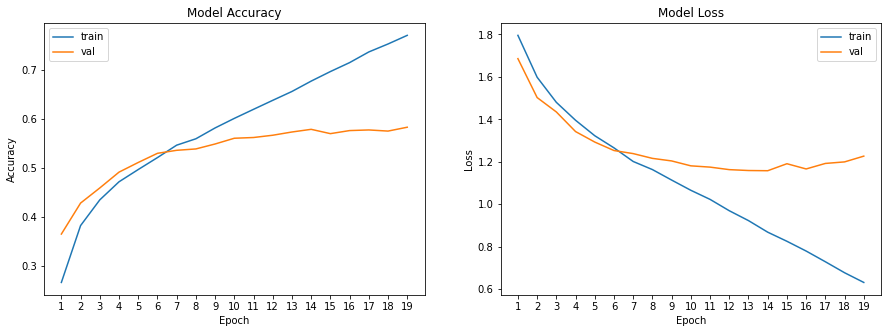

In [57]:
plot_model_history(history_custom_model)

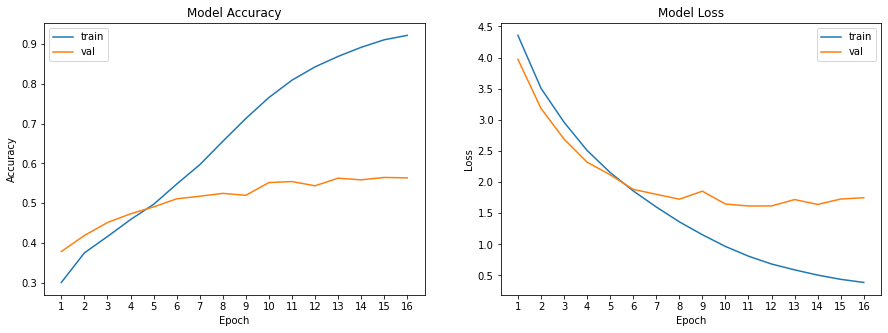

In [38]:
plot_model_history(history_custom_model1)

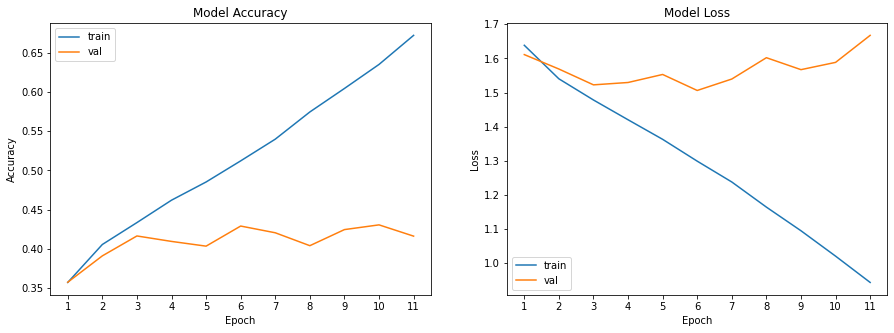

In [63]:
plot_model_history(history_vgg16)

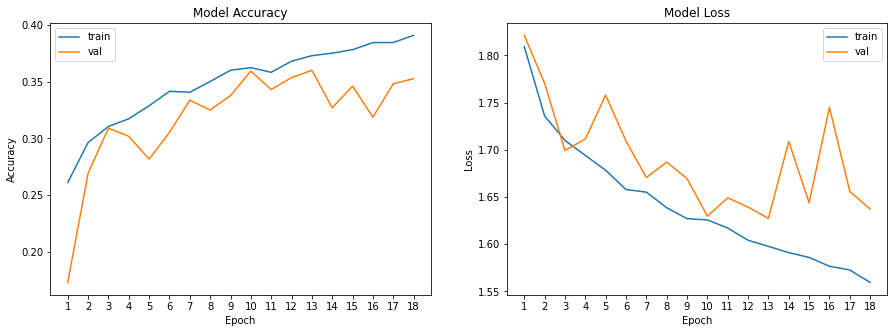

In [41]:
plot_model_history(history_resNet50_model)

In [3]:
PATH = 'models/'
def load_model(name='custom_modelNet'):
    new_model = tf.keras.models.load_model(PATH + name+'.h5')
    return new_model

In [43]:
def test_model(new_model):
    loss, acc = new_model.evaluate(test_data, verbose=2)
    print('model, accuracy: {:5.2f}%'.format(100 * acc))

In [40]:
custom_model = load_model('custom_modelNet')

In [44]:
test_model(custom_model)

225/225 - 18s - loss: 1.1686 - accuracy: 0.5699
model, accuracy: 56.99%


In [45]:
custom_model1 = load_model('custom_model1Net')

In [46]:
test_model(custom_model1)

225/225 - 17s - loss: 1.5691 - accuracy: 0.5606
model, accuracy: 56.06%


In [47]:
vgg16_model = load_model('vgg16Net')

In [48]:
test_model(vgg16_model)

225/225 - 18s - loss: 1.4927 - accuracy: 0.4355
model, accuracy: 43.55%


In [50]:
resnet50_model = load_model('resnet50Net')

In [51]:
test_model(resnet50_model)

225/225 - 21s - loss: 1.6281 - accuracy: 0.3605
model, accuracy: 36.05%


In [35]:
from functions import emotion_detection
#pass model for
emotion_detection(custom_model)